
# 🥊📊 UFC Data Analysis — Winner vs Loser (Portfolio Edition)

**Goal:** Identify which fight stats correlate with winning.

**Scope:** Modern UFC fights (dataset ends at 30 Aug; update instructions included).

**Why these stats?**
- **Significant Strikes** and **Knockdowns** capture striking dominance.
- **Takedowns** and **Submission Attempts** capture grappling control and finishing pressure.


### Setup

In [157]:
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Plot theme
sns.set_theme(style="whitegrid")


### Load Data

In [158]:
event_df = pd.read_csv("ufc_data/ufc_event_data.csv")
fighter_df = pd.read_csv("ufc_data/ufc_fighters.csv")

display(event_df.head())
display(fighter_df.head())


,Event Name,Event Date,Result,Fighter1,Fighter2,KD,Strikes,TD,Sub,Weight Class,Method,Round,Time
0,UFC Fight Night: Walker vs. Zhang,"August 23, 2025",Johnny Walker,Johnny Walker,Zhang Mingyang,1-0,50-20,0-0,0-0,Light Heavyweight,KO/TKO-Punches,2,2:37
1,UFC Fight Night: Walker vs. Zhang,"August 23, 2025",Aljamain Sterling,Aljamain Sterling,Brian Ortega,0-0,124-55,3-0,0-0,Catch Weight,U-DEC,5,5:00
2,UFC Fight Night: Walker vs. Zhang,"August 23, 2025",Sergei Pavlovich,Sergei Pavlovich,Waldo Cortes-Acosta,0-0,61-45,0-0,0-0,Heavyweight,U-DEC,3,5:00
3,UFC Fight Night: Walker vs. Zhang,"August 23, 2025",Sumudaerji,Sumudaerji,Kevin Borjas,0-0,73-16,0-0,0-0,Flyweight,U-DEC,3,5:00
4,UFC Fight Night: Walker vs. Zhang,"August 23, 2025",Taiyilake Nueraji,Taiyilake Nueraji,Kiefer Crosbie,0-0,27-2,1-0,0-0,Welterweight,KO/TKO-Elbows,1,3:33


,First Name,Last Name,Nickname,Height,Weight,Reach,Stance,Wins,Losses,Draws
0,Tom,Aaron,NaN,--,155 lbs.,--,NaN,5,3,0
1,Danny,Abbadi,The Assassin,"5' 11""",155 lbs.,--,Orthodox,4,6,0
2,Nariman,Abbasov,Bayraktar,"5' 8""",155 lbs.,"66.0""",Orthodox,28,4,0
3,Darion,Abbey,NaN,"6' 2""",265 lbs.,"80.0""",Orthodox,9,5,0
4,David,Abbott,Tank,"6' 0""",265 lbs.,--,Switch,10,15,0


### Cleaning & Standardization

In [159]:

# --- Fighter table cleanup
fighter_df = fighter_df.copy()
if set(["First Name","Last Name"]).issubset(fighter_df.columns):
    fighter_df["Name"] = fighter_df["First Name"].str.strip() + " " + fighter_df["Last Name"].str.strip()
    fighter_df = fighter_df.drop(columns=[c for c in ["Nickname","First Name","Last Name"] if c in fighter_df.columns])

# --- Event table cleanup
event_df = event_df.copy()

# Dates to datetime
if "Event Date" in event_df.columns:
  event_df["Event Date"] = pd.to_datetime(event_df["Event Date"], errors="coerce")

# Column renaming for clarity (use what's present)
renaming = {
  "Fighter1": "Winner",
  "Fighter2": "Loser",
  "KD": "Knockdowns",
  "Sig. str.": "Significant Strikes",
  "Td": "Takedowns",
  "Sub. att": "Submission Attempts",
}
event_df = event_df.rename(columns={k:v for k,v in renaming.items() if k in event_df.columns})

# Derive Winner/Loser columns from paired string fields when needed
# Many scrapes store stats like '50-20' (winner-loser). Parse into two numeric columns.
def _split_pair(series):
  s = series.astype(str)
  # Extract integers around a hyphen, tolerating spaces
  out = s.str.extract(r"\s*(\d+)\s*-\s*(\d+)\s*")
  out = out.rename(columns={0: 'win', 1: 'loss'})
  out['win'] = pd.to_numeric(out['win'], errors='coerce')
  out['loss'] = pd.to_numeric(out['loss'], errors='coerce')
  return out

# Map raw aggregated columns to canonical Winner/Loser targets
pair_sources = [
    ('Strikes', 'Sig Strikes'),
    ('TD', 'Takedowns Landed'),
    ('Sub', 'Submission Attempts'),
    ('Knockdowns', 'Knockdowns'),  # may have been renamed from 'KD' above
]
for src, label in pair_sources:
  if src in event_df.columns:
    parsed = _split_pair(event_df[src])
    event_df[f'Winner {label}'] = parsed['win']
    event_df[f'Loser {label}']  = parsed['loss']

# Winner/Loser stat columns (for side-by-side comparison)
# Expect columns like "Winner Sig Strikes", "Loser Sig Strikes" etc.
candidate_pairs = [
  ("Winner Sig Strikes", "Loser Sig Strikes"),
  ("Winner Takedowns Landed", "Loser Takedowns Landed"),
  ("Winner Submission Attempts", "Loser Submission Attempts"),
  ("Winner Knockdowns", "Loser Knockdowns"),
]
present_pairs = [(win,loss) for (win,loss) in candidate_pairs if win in event_df.columns and loss in event_df.columns]

# Basic NA handling
na_report = event_df.isna().sum().sort_values(ascending=False)
display(pd.DataFrame({"missing": na_report[na_report>0]}))

# Simple imputation for numeric analytical columns (median)
for win, loss in present_pairs:
  for c in (win, loss):
    if event_df[c].isna().any():
      event_df[c] = event_df[c].fillna(event_df[c].median())


,missing


### Descriptive Statistics

In [160]:

desc = event_df.select_dtypes(include="number").describe().T
display(desc.head(12))


,count,mean,std,min,25%,50%,75%,max
Round,2863.0,2.462801,1.035328,1.0,2.0,3.0,3.0,5.0
Winner Sig Strikes,2863.0,53.330073,39.557984,0.0,23.0,45.0,76.0,445.0
Loser Sig Strikes,2863.0,37.409710,31.944442,0.0,12.0,31.0,55.0,271.0
Winner Takedowns Landed,2863.0,1.417045,2.020168,0.0,0.0,1.0,2.0,14.0
Loser Takedowns Landed,2863.0,0.658750,1.198590,0.0,0.0,0.0,1.0,9.0
Winner Submission Attempts,2863.0,0.427873,0.814967,0.0,0.0,0.0,1.0,7.0
Loser Submission Attempts,2863.0,0.155781,0.502447,0.0,0.0,0.0,0.0,5.0
Winner Knockdowns,2863.0,0.364303,0.606577,0.0,0.0,0.0,1.0,6.0
Loser Knockdowns,2863.0,0.054838,0.243999,0.0,0.0,0.0,0.0,2.0


### Winner vs Loser — Mean Comparison (4 stats)

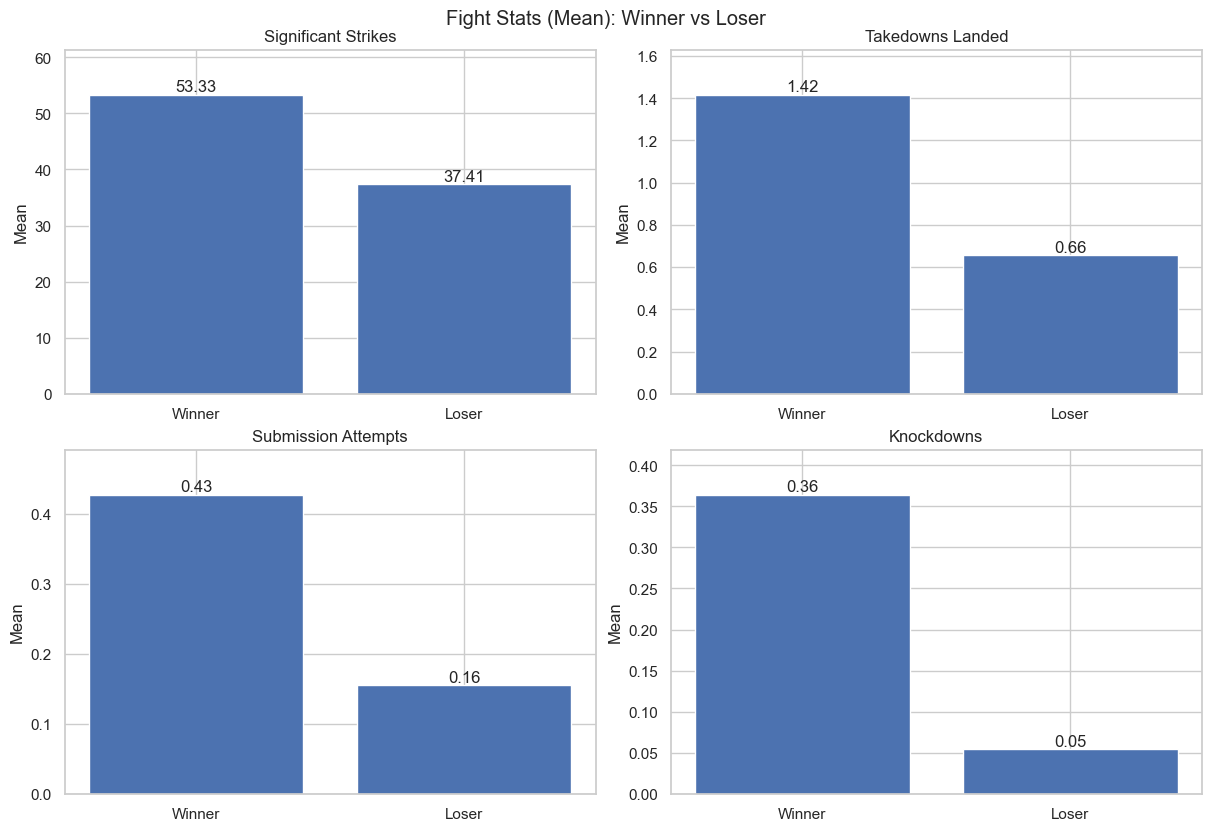

In [161]:

order = ["Significant Strikes", "Takedowns Landed", "Submission Attempts", "Knockdowns"]
# Backward compatibility with slightly different column names
canonical_map = {
  "Significant Strikes": ("Winner Sig Strikes","Loser Sig Strikes"),
  "Takedowns Landed": ("Winner Takedowns Landed","Loser Takedowns Landed"),
  "Submission Attempts": ("Winner Submission Attempts","Loser Submission Attempts"),
  "Knockdowns": ("Winner Knockdowns","Loser Knockdowns"),
}
available = [s for s in order if set(canonical_map[s]).issubset(event_df.columns)]


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), constrained_layout=True)
axes = axes.ravel()

for ax, stat in zip(axes, available):
  wcol, lcol = canonical_map[stat]
  means = [event_df[wcol].mean(), event_df[lcol].mean()]
  bars = ax.bar(["Winner","Loser"], means)
  ax.set_title(stat)
  ax.set_ylabel("Mean")

  # y-limit padding
  ymax = max(means) if len(means) else 1.0
  ax.set_ylim(0, ymax * 1.15 if ymax > 0 else 1)

  # annotate bars
  for idx, val in enumerate(means):
    ax.text(idx, val, f"{val:.2f}", ha="center", va="bottom")


plt.suptitle("Fight Stats (Mean): Winner vs Loser", y=1.02)
plt.show()



**Takeaway:** Winners typically lead in striking and/or grappling pressure; the annotated values make the magnitude of differences obvious at a glance.


###  How Did the Fights End?

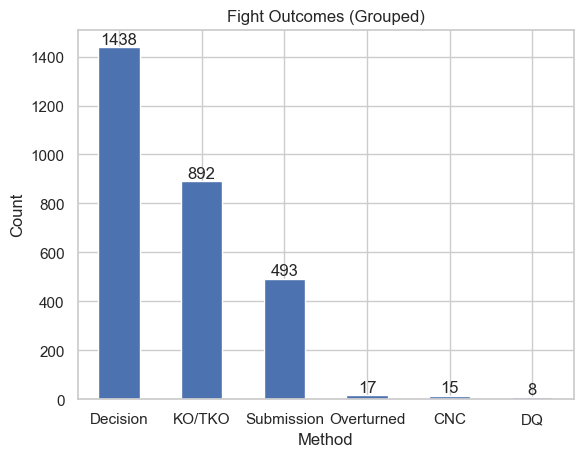

,count,pct
Method,,
Decision,1438,0.502
KO/TKO,892,0.312
Submission,493,0.172
Overturned,17,0.006
CNC,15,0.005
DQ,8,0.003


In [162]:

# Create a normalized 'Method (grouped)' label
method_col = None
for c in ["Method","Fight Ended","Ending Method"]:
  if c in event_df.columns:
    method_col = c
    break

if method_col is None:
  raise ValueError("Could not find a column that indicates fight method (e.g., 'Method').")

method_map = {
  r".*KO/TKO.*": "KO/TKO",
  r".*SUB.*": "Submission",
  r".*Overturned.*": "Overturned",
  r".*DEC.*": "Decision",
}
method_grouped = event_df[method_col].astype(str).replace(method_map, regex=True)
vc = method_grouped.value_counts(dropna=False).sort_values(ascending=False)

ax = vc.plot(kind="bar")
ax.set_title("Fight Outcomes (Grouped)")
ax.set_ylabel("Count")
for i, v in enumerate(vc.values):
  ax.text(i, v, str(v), ha="center", va="bottom")
plt.xticks(rotation=0)
plt.show()

vc.to_frame("count").assign(pct=lambda d: d["count"].div(d["count"].sum()).round(3)).head(10)



**Takeaway:** Mos fights finish via a decision; KO/TKO and Submissions form the bulk of finishes. This baseline informs which skills tend to be decisive.


### Submission Breakdown

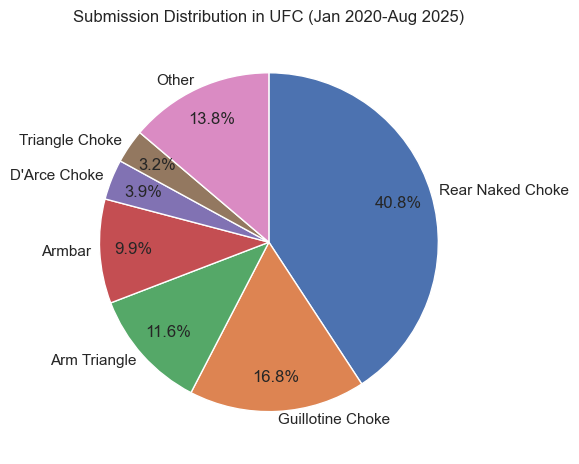

In [163]:
s = pd.read_csv("ufc_data/ufc_event_data.csv")["Method"]

subs = s[s.str.contains("SUB", na=False)]

# Clean labels → e.g., "SUB - REAR-NAKED-CHOKE" → "Rear Naked Choke"
labels = (subs
          .str.replace(r"^SUB\s*-\s*", "", regex=True)
          .str.replace("-", " ")
          .str.strip()
          .str.title())


counts = labels.value_counts()

# 5) Aggregate small categories to "Other" to reduce crowding
min_share = 0.03  # 3% 
share = counts / counts.sum()
major = counts[share >= min_share]
other_sum = counts[share < min_share].sum()
if other_sum:
  counts_plot = pd.concat([major, pd.Series({"Other": other_sum})])
else:
  counts_plot = major

plt.title("Submission Distribution in UFC (Jan 2020-Aug 2025)")
plt.pie(
  counts_plot.values,
  labels=counts_plot.index,
  autopct="%1.1f%%",
  startangle=90,
  counterclock=False,
  pctdistance=0.8,
  labeldistance=1.05,
)
plt.tight_layout()
plt.show()



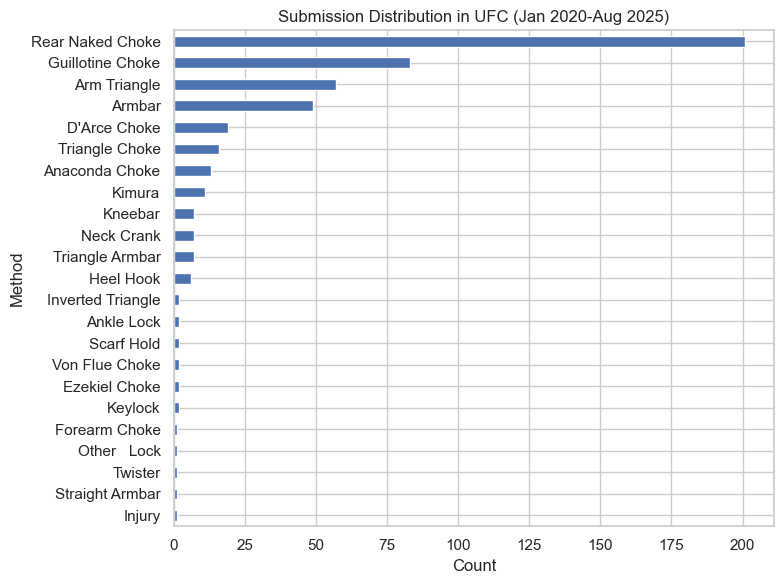

In [164]:
plt.figure(figsize=(8, 6))
counts.sort_values().plot(kind="barh")
plt.title("Submission Distribution in UFC (Jan 2020-Aug 2025)")
plt.xlabel("Count")
plt.tight_layout()
plt.show()


**Takeaway:** A few submissions (e.g., RNC, Guillotine) account for a large share; grouping rare entries keeps the chart legible.


### Correlation Snapshot (Numeric Columns)

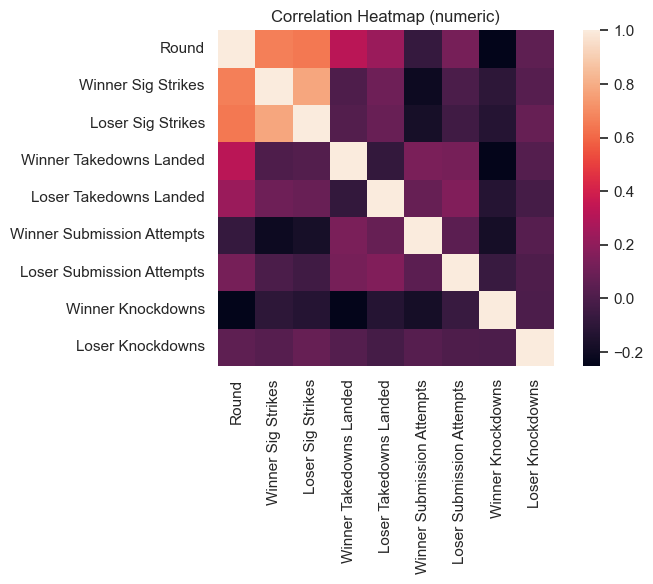

In [165]:

num = event_df.select_dtypes(include="number")
corr = num.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, square=True, cbar=True)
plt.title("Correlation Heatmap (numeric)")
plt.tight_layout()
plt.show()


### Stats Per Minute
This looks at stats per minute, you can look at how active you have to over your opponents to win a fight. I will be using fights which have ended in a decision since activity per minute stats can dictate how the judges score who wins the round, and the fights. 

In [166]:
event_df.head()

,Event Name,Event Date,Result,Winner,Loser,Knockdowns,Strikes,TD,Sub,Weight Class,Method,Round,Time,Winner Sig Strikes,Loser Sig Strikes,Winner Takedowns Landed,Loser Takedowns Landed,Winner Submission Attempts,Loser Submission Attempts,Winner Knockdowns,Loser Knockdowns
0,UFC Fight Night: Walker vs. Zhang,2025-08-23,Johnny Walker,Johnny Walker,Zhang Mingyang,1-0,50-20,0-0,0-0,Light Heavyweight,KO/TKO-Punches,2,2:37,50,20,0,0,0,0,1,0
1,UFC Fight Night: Walker vs. Zhang,2025-08-23,Aljamain Sterling,Aljamain Sterling,Brian Ortega,0-0,124-55,3-0,0-0,Catch Weight,U-DEC,5,5:00,124,55,3,0,0,0,0,0
2,UFC Fight Night: Walker vs. Zhang,2025-08-23,Sergei Pavlovich,Sergei Pavlovich,Waldo Cortes-Acosta,0-0,61-45,0-0,0-0,Heavyweight,U-DEC,3,5:00,61,45,0,0,0,0,0,0
3,UFC Fight Night: Walker vs. Zhang,2025-08-23,Sumudaerji,Sumudaerji,Kevin Borjas,0-0,73-16,0-0,0-0,Flyweight,U-DEC,3,5:00,73,16,0,0,0,0,0,0
4,UFC Fight Night: Walker vs. Zhang,2025-08-23,Taiyilake Nueraji,Taiyilake Nueraji,Kiefer Crosbie,0-0,27-2,1-0,0-0,Welterweight,KO/TKO-Elbows,1,3:33,27,2,1,0,0,0,0,0


In [167]:
df_decisions = event_df[event_df['Method'] == ('U-DEC' or 'S-DEC')]
df_decisions = df_decisions.drop(columns=[
    'Event Date',
    'Result',
    'Time',
    'Knockdowns',
    'Strikes',
    'TD',
    'Sub'
])

df_decisions.head()

,Event Name,Winner,Loser,Weight Class,Method,Round,Winner Sig Strikes,Loser Sig Strikes,Winner Takedowns Landed,Loser Takedowns Landed,Winner Submission Attempts,Loser Submission Attempts,Winner Knockdowns,Loser Knockdowns
1,UFC Fight Night: Walker vs. Zhang,Aljamain Sterling,Brian Ortega,Catch Weight,U-DEC,5,124,55,3,0,0,0,0,0
2,UFC Fight Night: Walker vs. Zhang,Sergei Pavlovich,Waldo Cortes-Acosta,Heavyweight,U-DEC,3,61,45,0,0,0,0,0,0
3,UFC Fight Night: Walker vs. Zhang,Sumudaerji,Kevin Borjas,Flyweight,U-DEC,3,73,16,0,0,0,0,0,0
5,UFC Fight Night: Walker vs. Zhang,Gauge Young,Maheshate,Lightweight,U-DEC,3,112,66,3,0,0,0,0,0
7,UFC Fight Night: Walker vs. Zhang,Rongzhu,Austin Hubbard,Lightweight,U-DEC,3,101,75,0,2,0,0,0,0


In [168]:
strike_differential = (df_decisions['Winner Sig Strikes'] - df_decisions['Loser Sig Strikes']) / df_decisions['Round']
takedown_differential = (df_decisions['Winner Takedowns Landed'] - df_decisions['Loser Takedowns Landed']) / df_decisions['Round']
sub_differential = (df_decisions['Winner Submission Attempts'] - df_decisions['Loser Submission Attempts']) / df_decisions['Round']
kd_differential = (df_decisions['Winner Knockdowns'] - df_decisions['Loser Knockdowns']) / df_decisions['Round']

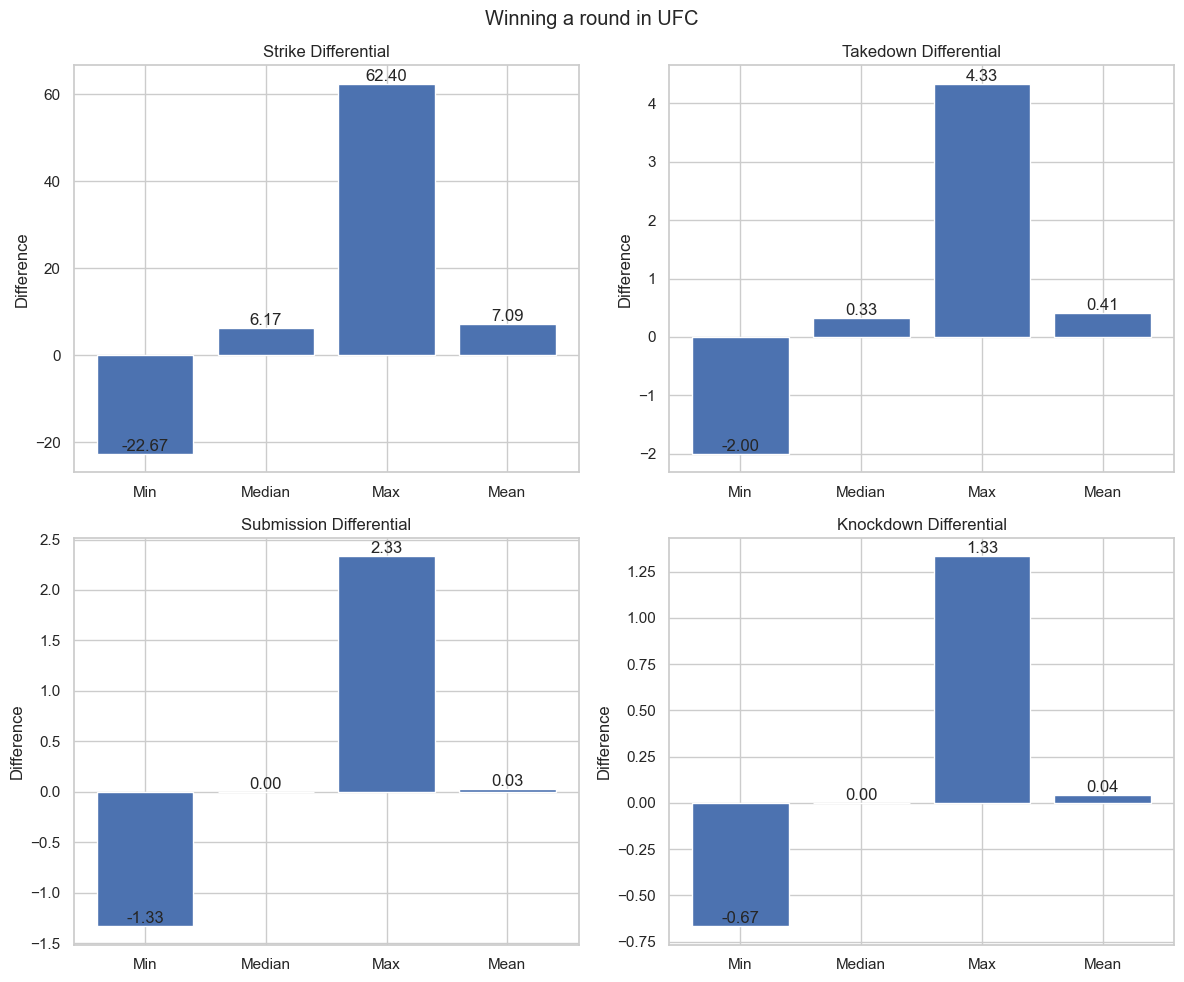

In [169]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Winning a round in UFC')

differentials = [
    (strike_differential, 'Strike Differential'),
    (takedown_differential, 'Takedown Differential'),
    (sub_differential, 'Submission Differential'),
    (kd_differential, 'Knockdown Differential')
]

axes = ax.flatten()

for idx, (diff_series, title) in enumerate(differentials):
    min_val = diff_series.min()
    median_val = diff_series.median()
    max_val = diff_series.max()
    mean_val = diff_series.mean()
    
    bars = axes[idx].bar(
        ['Min', 'Median', 'Max', 'Mean'], 
        [min_val, median_val, max_val, mean_val],
    )
    
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(
            bar.get_x() + bar.get_width()/2, 
            height,
            f'{height:.2f}',
            ha='center', 
            va='bottom'
        )
    
    axes[idx].set_title(title)
    axes[idx].set_ylabel('Difference')

plt.tight_layout()
plt.show()

Therefore it seems like the most likely way to win a fight by decision (meaning the fight takes a while to determine the winner), is to land around 6-7 more strikes than your opponent in a single round (5 min in UFC). Takedowns also matter slightly, however the mean is  0.33 takedowns per round which means an average of 1 takedown in a 3 round fight. Knockdowns and submissions attempts per round seem to not matter, most likely since submissions and knockdowns are associated with a fight ending.